# Exam, Part 2

A dynamic study of CAPM and "betting against beta." The main task involves building a trading strategy that bets against CAPM. It is not sure that it will be a success.

In [9]:
using Pkg, Printf, Dates, Statistics, DelimitedFiles, Plots, DataFrames   #you shouldn't need any other packages

include("jlFiles/printmat.jl");

In [10]:
#using Pkg
#Pkg.update()
#Pkg.add("DataFrames")

In [11]:
using Plots

gr(size=(480,320))
default(fmt = :svg)

# Load Data

a. Import `Data/100_Portfolios_10x10.CSV` and convert all `-99.99` to `NaN`. Extract columns `2:end` and call that matrix `R`.

b. Import `Data/FFmFactors.csv` and extract `Rf` and `Rme` (columns 5 and 2).

c. Calculate excess returns as `Re = R .- Rf`

d. There are a few missing values in `Re`. For simplicity, convert them to 0.

In [12]:
File1 = "Data/100_Portfolios_10x10.CSV"
x   = readdlm(File1,',',skipstart=1)          #reading the csv file
ym  = round.(Int,x[:,1])                      #yearmonth, like 200712
dN  = Date.(string.(ym),"yyyymm")             #convert to Julia Date
R   = convert.(Float64,x[:,2:end])
replace!(R,-99.99=>NaN)                       #missing=>NaN

File2 = "Data/FFmFactors.csv"
x   = readdlm(File2,',',skipstart=1)          #reading the csv file
Rf  = x[:,5]
Rme = x[:,2]

Re  = R .- Rf
replace!(x->isunordered(x) ? 0 : x,Re)        #set missing Re to 0: as if no investment
(T,n) = size(Re)

(756, 100)

# Task 1: CAPM Regressions over Moving Data Windows

Let `x = [Rme ones(T)]`. Estimate the regression `Re[t-59:t,i]` on `x[t-59:t]` and record the slope cofefficient (that is, the coefficient on `Rme`) results in a matrix (`b[t,i]`).

Plot `b[:,11]` and `b[:,89]` in a time series plot, that is, for asset 11 and 89.

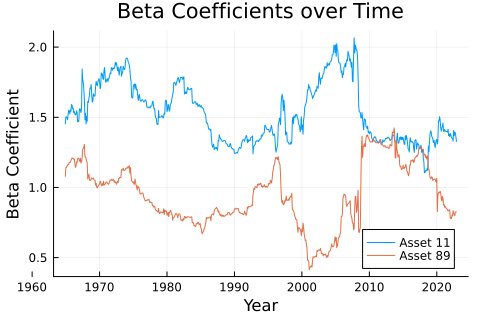

In [13]:
# Given: Re, Rf, Rme, R
# Re = Rf + β*(Rm - Rf)
# β = Covariance (Re, Rm) / Variance (Rm)
window_size = 60
b = [cov(Re[t-window_size+1:t, i], Rme[t-window_size+1:t]) / var(Rme[t-window_size+1:t]) for i in 1:n, t in window_size:T]
plot_dates = dN[window_size:T]
year_ticks = collect(1960:10:2022)  # Generate ticks for every 10 year
date_ticks = [Date(y, 1, 1) for y in year_ticks] # This is needed for the ticks to work

plot(plot_dates, b[11,:], label = "Asset 11", title = "Beta Coefficients over Time", xlabel = "Year", xticks=(date_ticks, string.(year_ticks)), ylabel = "Beta Coefficient", legend = :bottomright)
plot!(plot_dates, b[89,:], label = "Asset 89")

# Task 2: Rank Assets According to the Betas

a. For each period `t`, rank the assets according to the beta estimated over `t-59:t`, that is, rank `b[t,:]`. Clearly, this calculation can be done for `t=60:T`.
 
b. Plot the rank of assets 11 and 89 in a time series plot. Restrict the vertical axis to (0,100).

Hint: the function `rankPs()` might be useful

In [14]:
"""
    rankPs(x)
Calculates the ordinal rank of eack element in a vector `x`. As an aternative, use `ordinalrank` from the `StatsBase.jl` package
"""
rankPs(x) = invperm(sortperm(x))
println("Example of how rankPs() works")
x = [9,7,8]
printmat(x,rankPs(x);colNames=["data","rank"])

Example of how rankPs() works


      data      rank
     9         3    
     7         1    
     8         2    



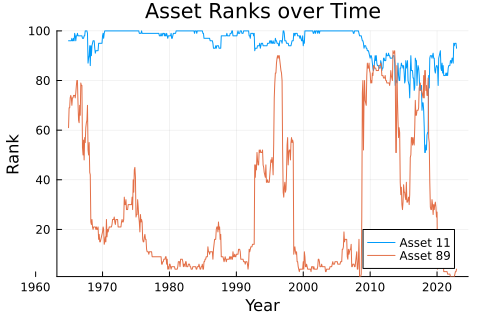

In [15]:
asset_ranks = [rankPs(b'[t, :]) for t in 1:(T-window_size+1)]
## The other structure is really annoying to work with imo Vector{Vector}
asset_ranks = hcat(asset_ranks...)

# We use the dates etc from before
plot(plot_dates, asset_ranks[11,:], label="Asset 11", title="Asset Ranks over Time", xlabel="Year", ylabel="Rank", xticks=(date_ticks, string.(year_ticks)), ylim=(1, 100), legend=:bottomright)
plot!(plot_dates, asset_ranks[89,:], label="Asset 89")

# Task 3: Create Portfolios and Calculate Portfolio Returns

a. For each period `t` (in `61:T`), create a portfolio which weights `1/10` for each of the assets with the 10 lowest ranks in `t-1` according to the point above (that is, those with the lowest betas). All other assets have zero weights. Save the weights as `wL[t,:]` in a matrix. Create the return in `t` and call the return series `RL`.

b. Do the same but for the assets with the 10 highest ranks and call the weights `wH` and the return series `RH`.

c. Plot `wL` for assets 11 and 89. Then plot `wH` for the same assets. Restrict the vertical axis to (0,1/10).

d. Calculate the frequency (over `t=61:T`) of asset 1 having a positive weight in `WL`. Do the same for `wH`. Print as 10x10 matrices in such a way that the first 10 assets are in row 1, the next 10 assets in row 2, etc.

In [16]:
# The betas are already from timestamps 60:T, so by going 61:T, we go 1:T-60
T_min_60 = T - 60
wL = zeros(T_min_60, n)
wH = zeros(T_min_60, n)

RL = zeros(T_min_60)
RH = zeros(T_min_60)

for t in 1:T_min_60
    rankings = sortperm(asset_ranks[:, t])
    wL[t, rankings[1:10]] .= 1/10
    wH[t, rankings[91:100]] .= 1/10
    # We calculate the value of the portfolio at time t+1 (which is t but i used t for t-1)
    RL[t] = sum(wL[t, :] .* Re[t+1, :])
    RH[t] = sum(wH[t, :] .* Re[t+1, :])
end

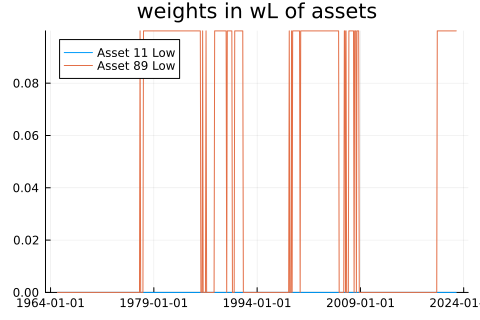

In [17]:
plot_dates = dN[61:T]
plot(plot_dates, wL[:, 11], title="weights in wL of assets", label="Asset 11 Low", ylim=(0, 1/10))
plot!(plot_dates, wL[:, 89], label="Asset 89 Low")

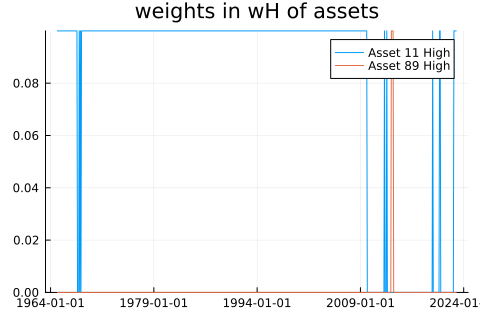

In [18]:
plot(plot_dates, wH[:, 11], title="weights in wH of assets",label="Asset 11 High", ylim=(0, 1/10))
plot!(plot_dates, wH[:, 89], label="Asset 89 High")

In [19]:
# We could also use the sum() and multiply by 10 as all weights are 1/10, i didn't measure which one is faster
frequencies = sum(wL .> 0, dims=1) ./ T_min_60
freq_wL = reshape(frequencies, 10, 10)'
@assert freq_wL[1,4] == frequencies[4] "This should be the same"
printmat(freq_wL)

     0.027     0.000     0.043     0.000     0.007     0.001     0.142     0.216     0.182     0.174
     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.024     0.042     0.016
     0.000     0.000     0.000     0.000     0.000     0.004     0.076     0.102     0.053     0.000
     0.000     0.000     0.000     0.000     0.000     0.040     0.006     0.000     0.004     0.047
     0.000     0.000     0.000     0.000     0.000     0.020     0.037     0.111     0.088     0.022
     0.000     0.000     0.001     0.000     0.003     0.187     0.116     0.165     0.149     0.001
     0.000     0.022     0.036     0.023     0.068     0.079     0.144     0.082     0.070     0.148
     0.056     0.000     0.013     0.037     0.088     0.007     0.216     0.204     0.068     0.029
     0.057     0.026     0.131     0.106     0.182     0.339     0.352     0.386     0.407     0.132
     0.306     0.273     0.409     0.368     0.599     0.552     0.547     0.580     0.284 

In [20]:
frequencies = sum(wH .> 0, dims=1) ./ T_min_60
freq_wH = reshape(frequencies, 10, 10)'
printmat(freq_wH)

     0.497     0.320     0.171     0.147     0.004     0.037     0.013     0.034     0.000     0.070
     0.783     0.618     0.205     0.068     0.000     0.001     0.032     0.009     0.003     0.178
     0.826     0.414     0.128     0.055     0.036     0.001     0.001     0.007     0.016     0.293
     0.700     0.164     0.076     0.000     0.003     0.000     0.000     0.000     0.022     0.376
     0.639     0.060     0.001     0.001     0.001     0.003     0.000     0.000     0.055     0.237
     0.540     0.033     0.001     0.000     0.004     0.000     0.059     0.000     0.017     0.089
     0.307     0.019     0.017     0.001     0.024     0.000     0.000     0.006     0.017     0.246
     0.352     0.000     0.000     0.013     0.000     0.043     0.000     0.000     0.000     0.213
     0.198     0.000     0.001     0.000     0.000     0.000     0.017     0.000     0.006     0.234
     0.000     0.000     0.000     0.000     0.000     0.000     0.000     0.085     0.032 

# Task 4: Show Basic Return Statistics

a. For each `t`, calculate the average return across the 100 assets.

b. For `t=61:T`, calculate the the mean, std and Sharpe ratio of `RL`, `RH`, `Rme` and the average return from point a. Also, calculate the intercepts and the slope coefficients (for each of the 4 return series) on a regression on `[1 Rme]`.

c. Annualise the mean by 12, the std by sqrt(12) and the intercept by 12. Calculate the SR on the annalused values. Don't anualise the slope coefficients. Show results in a table.

In [21]:
""" 
y = mx + b
I think by intercepts b from the regression is ment, b = intercepts
Slope coefficient = m
"""

function linear_regression(X, y)
    b = cov(X[:, 2], y) / var(X[:, 2]) 
    a = mean(y) - b * mean(X[:, 2])    
    return a, b
end

linear_regression (generic function with 1 method)

In [25]:
#a
average_returns = [mean(Re[t, :]) for t in 1:T]
RF_relevant = mean(Rf[61:end])
#b
mean_RL = mean(RL)
std_RL = std(RL)
sharpe_RL = (mean_RL .- RF_relevant)  / std_RL

mean_RH = mean(RH)
std_RH = std(RH)
sharpe_RH = (mean_RH .- RF_relevant) / std_RH

mean_Rme = mean(Rme[61:end])
std_Rme = std(Rme[61:end])
sharpe_Rme = (mean_Rme .- RF_relevant) / std_Rme

mean_average_return = mean(average_returns[61:end])
std_average_return = std(average_returns[61:end])
sharpe_average_return = (mean_average_return .- RF_relevant) / std_average_return

Rme_adjusted = Rme[61:end]
ones_rme = hcat(ones(length(Rme_adjusted)), Rme_adjusted)

# Perform regressions
intercept_RL, slope_RL = linear_regression(ones_rme, RL)
intercept_RH, slope_RH = linear_regression(ones_rme, RH)
intercept_Rme, slope_Rme = linear_regression(ones_rme, Rme_adjusted)
intercept_average_return, slope_average_return = linear_regression(ones_rme, average_returns[61:end])

(0.15766145421694677, 1.0931943062787477)

In [26]:
#C
annual_mean_RF = RF_relevant * 12

annual_mean_RL = mean_RL * 12
annual_std_RL = std_RL * sqrt(12)
annual_sharpe_RL = (annual_mean_RL .- annual_mean_RF) / annual_std_RL

annual_mean_RH = mean_RH * 12
annual_std_RH = std_RH * sqrt(12)
annual_sharpe_RH = (annual_mean_RH .- annual_mean_RF) / annual_std_RH

annual_mean_Rme = mean_Rme * 12
annual_std_Rme = std_Rme * sqrt(12)
annual_sharpe_Rme = (annual_mean_Rme .- annual_mean_RF) / annual_std_Rme

annual_mean_average_return = mean_average_return * 12
annual_std_average_return = std_average_return * sqrt(12)
annual_sharpe_average_return = (annual_mean_average_return .- annual_mean_RF) / annual_std_average_return


stats_df = DataFrame(
    Series = repeat(["RL", "RH", "Rme", "Average Return"], inner = 2),
    Type = repeat(["Non-Annualized", "Annualized"], outer = 4),
    Mean = [mean_RL, annual_mean_RL, mean_RH, annual_mean_RH, mean_Rme, annual_mean_Rme, mean_average_return, annual_mean_average_return],
    Std = [std_RL, annual_std_RL, std_RH, annual_std_RH, std_Rme, annual_std_Rme, std_average_return, annual_std_average_return],
    Sharpe = [sharpe_RL, annual_sharpe_RL, sharpe_RH, annual_sharpe_RH, sharpe_Rme, annual_sharpe_Rme, sharpe_average_return, annual_sharpe_average_return],
    Intercept = repeat([intercept_RL, intercept_RH, intercept_Rme, intercept_average_return], inner = 2),
    Slope = repeat([slope_RL, slope_RH, slope_Rme, slope_average_return], inner = 2)
)

# Print the DataFrame
println(stats_df)


8×7 DataFrame
 Row │ Series          Type            Mean      Std       Sharpe     Intercept  Slope      
     │ String          String          Float64   Float64   Float64    Float64    Float64    
─────┼──────────────────────────────────────────────────────────────────────────────────────
   1 │ RL              Non-Annualized  0.685561   3.83736  0.0837765   0.682543   0.0056137
   2 │ RL              Annualized      8.22673   13.293    0.29021     0.682543   0.0056137
   3 │ RH              Non-Annualized  0.568111   7.5393   0.0270623   0.584101  -0.0297478
   4 │ RH              Annualized      6.81733   26.1169   0.0937465   0.584101  -0.0297478
   5 │ Rme             Non-Annualized  0.537529   4.54834  0.0381344   0.0        1.0
   6 │ Rme             Annualized      6.45034   15.7559   0.132101    0.0        1.0
   7 │ Average Return  Non-Annualized  0.745285   5.31389  0.0717373   0.157661   1.09319
   8 │ Average Return  Annualized      8.94342   18.4079   0.248505    0.1576

In [24]:
println("test")

test
